# Recurrent Neural Networks

# Introduction

The term <span style="color:orange">neural network</span> encompasses a wide variety of learning methods, although in a general way it can be said that a neural network is like a nonlinear statistical model defined by means of an arbitrarily large number of parameters.

Its structure is usually represented by a directed graph, i.e., a set of nodes (units or neurons) connected by edges.
Each node $i$ receives a numerical vector, processes it by applying a certain activation function -a nonlinear function- and returns the result to another node $j$ to which it is connected by an edge. Each edge has an associated weight $w_{ij}$, which determines the importance and sign of the connection. The neurons are stacked by the node $j$. Neurons are stacked in layers and in each layer an activation function is usually defined. Three types of layers can be distinguished in a neural network: the input layer receives the input data and consists of as many neurons as are necessary to train the proposed architecture; the output layer provides the result or predictions defined according to the problem; a series of hidden layers is placed between the two previous layers and combines the inputs with a set of weights and returns them after applying a given activation function, i.e., provides nonlinear transformations of the data in a chained fashion.

The training of a network consists of adjusting the parameters that define it by updating them at each step so that they approach the reference values (input data associated with the output data) provided. For this purpose, the data of the training set are provided to the network and a training set is generated. It is then compared with the actual observations and the parameters are adjusted so that the network output is closer to the actual data, for which the back propagation algorithm is used.
In this way, a neural network is capable of constructing complex relationships from the information contained in the data. from the information contained in the data provided.

As a general rule, neural networks converge after a certain training time to a sufficiently accurate model, although there are certain <span style="color:orange">hyperparameters</span> that can be adjusted to obtain the most optimal model possible. In this implementation, the following have been considered: <span style="color:orange">window size, number of neurons per layer, number of layers, dropout rate, type of neuron and activation function </span>.

There is, therefore, a large number of hyperparameters with which to construct a neural network, defining a large number of possible combinations of these (configurations). Consequently, obtaining an optimal configuration is a rather computationally expensive problem. Some methods to obtain optimal configurations are brute force search, random search, bayesian optimization, hyperband and BOHB (Bayesian optimization and hyperband). <span style="color:orange">Random search</span> is used here for simplicity.


# Data 

We will take the example univariate series of spanish covid data.

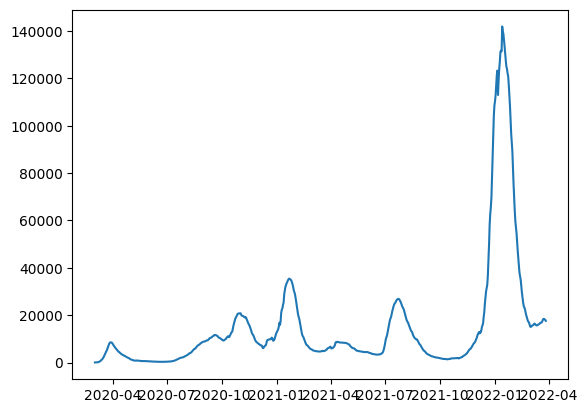

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# read covid data from disk
df = pd.read_csv('../data/spanish-covid-19-data-renave-07Jul2022.csv', parse_dates=['Date'], index_col='Date')
df = df['Infected']
plt.plot(df)
plt.show()

# Preprocessing

It is often said that one of the major advantages of neural networks over traditional statistical methods is that they require <span style="color:LightGreen">less initial preprocessing</span> of the data, do <span style="color:LightGreen">not require initial assumptions</span>, or that <span style="color:LightGreen">less technical knowledge is needed</span>. 
However, the data does have to undergo some pre-processing before being fed into the neural network and, although no specific assumptions have been made (yet), they tend to provide better results if some scaling is applied to the data. The steps implemented in the pre-processing are listed below. 

## 1. Split dataset into 1-dimensional subsets
The first step of this analysis is the division of the univariate series into three subsets. These subsets are: 
- <span style="color:LightSkyBlue">training data set</span>: to fit the parameters of the neural network with the data
- <span style="color:LightSkyBlue">validation data set</span>: to tune the hyperparameters of the network
- <span style="color:LightSkyBlue">test data set </span>: to assess the generalization and predictive ability of the model

<span style="color:red">Note: </span>Neural networks have a large number of parameters and hyperparameters to adjust and can be arbitrarily complex. This means that you need a large amount of data or data to match the complexity to get good results. If not enough data is available, the network is likely to be overfitted. 

## 2. Scale
In order for the network to capture the information correctly, the data must be scaled or normalized (note the difference). This also reduces computation time. To do this, the maximum ($\max_{\text{train}}$) and minimum ($\min_{\text{train}}$) values of train subset are taken and the following scaling formula is applied to each value of each subset:

$$\frac{(x - \min_{\text{train}})}{(\max_{\text{train}} - \min_{\text{train}})}$$

where $x$ can be any observation of any subset (train, validation or test). 

The goal is to place all observations on the scale $[0, 1]$.

<span style="color:red">Note: </span> We are always using known data from the train set in order not to introduce unknown information into the model. It may happen that in the validation or test subsets the maximum value exceeds the train value (similarly for the minimum). A correction is introduced to control this.  



## 3. Make dataset 2-dimensional (a supervised problem)

We are dealing with a univariate series, that is, a one-dimensional vector. The task of the neural network is to find the relationship of a series of input values $X$ with output values $Y$: $f(X)=Y$. It is therefore necessary to transform the available univariate series into input vectors $X$ related to output vectors $Y$ that maintain the temporal sense. In this sense, $X$ is the set of $window\_size$ past observed values and $Y$ is the set of $steps\_ahead$ values to be predicted. The two dimensions of $X$ are characterized by the number of predictors (defined by $window\_size$) and the number of observed time windows; the two dimensions of $Y$ are characterized by the number of $steps\_ahead$ and the number of observed time windows. 

To define some types of networks as RNN, three dimensions are required, not two: every input to RNN layer must be three-dimensional, where the dimensions are as follows: [batch, window_size, features]. In this case the series is one-dimensional so that features will always be 1.

# Grid search

Once the data is prepared, a mesh with hyperparameters is defined. This mesh is excessively large, so a random sample of $max\_configs$ combinations is taken. With each combination, a model is created and evaluated.

Define the path to store the results of the grid search.

In [15]:
import os

path_to_store_results = os.path.join('./models', 'rnn-results', 'evaluations')
path_to_save_models = os.path.join('./models', 'rnn-results', 'models')

Define class to perform random grid search:

In [16]:
from utils import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import itertools
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from utils import *
import json, os
import datetime

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set seed for reproducibility
seed=123

In [43]:
class rmsle(tf.keras.metrics.Metric):
    def __init__(self , name='rmsle', **kwargs):
        super(rmsle, self).__init__(name=name, **kwargs)
        self.error_array = None


    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.math.log(y_true)
        y_pred = tf.math.log(y_pred)

        error = y_pred-y_true

        error = tf.math.square(error)

        if self.error_array is not None:
            self.error_array = tf.concat([self.error_array,error],axis=0)
        else:
            self.error_array = error


        self.error_array = error

    def reset_state(self):
        self.error_array = None
    

    def result(self):
        total_error = self.error_array
        total_error = tf.math.reduce_mean(total_error)
        total_error = tf.math.sqrt(total_error)
        self.reset_states()
        return total_error


mirmsle = rmsle()

In [44]:
class paramsearch:
    """
    Grid search to get the best parameters

    Args:
        data (pd.DataFrame): univariate series with the data
        steps_ahead (int): number of steps ahead to forecast
        hyperparams (dict of lists): dict of hyperparams 
        split_sizes (tuple): sizes of train and validation sets. By default=(0.7,0.2).
                             (test size is 1-(0.7+0.2)=0.1 for default case)
        max_configs (int): max number of combinations to evaluate
        metrics (dict): metrics used in evaluation
    """

    def __init__(self, data, steps_ahead=14, max_configs=100, split_sizes=(0.7, 0.2), hyperparams=None, metrics=metrics):

        # store data
        self.data = data
        self.train_df = None
        self.val_df = None
        self.test_df = None

        # if no grid specified, define grid
        if hyperparams is None:
            self.hyperparams = {
                'window_size': [i for i in range(10, 25)],
                'num_neurons': [i for i in range(5, 20)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.5, 0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
        else:
            self.hyperparams = hyperparams

        # store attributes
        self.steps_ahead = steps_ahead
        self.max_configs = max_configs
        self.train_size = split_sizes[0]
        self.val_size = split_sizes[1]
        self.metrics = metrics
        self.tf_metrics = metrics = [
            # RMSLETF,
            mirmsle,
                                    'mae', 
                                    tf.keras.metrics.RootMeanSquaredError(), 
                                    tf.keras.metrics.MeanAbsolutePercentageError()
                                    ]

        # train config
        self.epochs = 100
        self.batch_size = 16

        # vars to store experiment results
        self.history_log = {}
        self.model_log = {}
        self.pandas_log = None
        self.all_data_from_model = {}

    def run_experiment(self, verbose=1):
        # set seed
        np.random.seed(seed)

        # generate grid
        hypergrid = list(self.generate_hypergrid())
        # subsample hypergrid (get only some combinations of hyperparameters)
        hypergrid = self.subsample_hypergrid(hypergrid)

        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)

        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. loop over hypergrid
        for hypercomb in hypergrid:
            try:
                if verbose:
                    print(hypercomb)

                # 3.1. make dataset
                X_train, Y_train = self.make_dataset(
                    window_size=hypercomb['window_size'], series=train_df_sc)
                X_val, Y_val = self.make_dataset(
                    window_size=hypercomb['window_size'], series=val_df_sc)
                X_test, Y_test = self.make_dataset(
                    window_size=hypercomb['window_size'], series=test_df_sc)

                # 3.2. build model
                model = self.build_model(hypercomb['num_layers'],
                                        hypercomb['num_neurons'],
                                        hypercomb['dropouts'],
                                        hypercomb['window_size'],
                                        hypercomb['layer_type'],
                                        hypercomb['activation_function'],
                                        self.tf_metrics)

                # 3.3. train model
                history = model.fit(X_train, Y_train, validation_data=(
                    X_val, Y_val), batch_size=self.batch_size, epochs=self.epochs,
                    verbose=0)

                # 3.4. store history in history dict
                self.history_log['_'.join(
                    [str(param) for param in hypercomb.values()])] = history

                # 3.5. store trained model in model dict
                self.model_log['_'.join([str(param)
                                        for param in hypercomb.values()])] = model

                # 3.6. evaluate model on validation set and store results
                result_val = self.evaluate_model(model, X_val, Y_val)
                result_val = {f'val_{k}':v for k,v in result_val.items()}
                # print(result_val)

                # 3.7. evaluate model on test set and store results
                result_test = self.evaluate_model(model, X_test, Y_test)
                result_test = {f'test_{k}':v for k,v in result_test.items()}
                # print(result_test)

                # 3.8. print combination and evaluation results on val and train
                newrow = pd.DataFrame({**hypercomb, **result_val, **result_test})
                # display(newrow)

                # 3.9. store all data from model in dict
                self.store_all_data(hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test)
                # add row to metric table
                if self.pandas_log is None:
                    self.pandas_log = newrow
                else:
                    self.pandas_log = pd.concat([self.pandas_log, newrow])

            except Exception as e:
                print(e)
                continue

    def generate_hypergrid(self):
        """Returns all possible combinations 
            of the hyperparameters"""
        keys = self.hyperparams.keys()
        vals = self.hyperparams.values()
        for instance in itertools.product(*vals):
            yield dict(zip(keys, instance))

    def subsample_hypergrid(self, hypergrid):
        """Returns subsamples of the hypergrid"""
        # get self.max_configs random combinations of hyperparameters combinations
        subsamples = random.sample(range(len(hypergrid)), self.max_configs)
        subsamples = [hypergrid[i] for i in subsamples]
        print(f'Number of configs to evaluate: {len(subsamples)}')
        print('-------------------------------------------------\n')
        return subsamples

    def univariate_train_test_split(self, data):
        """Splits the data into train, val and test sets"""
        # split data into univariate train, val and test sets
        n = len(data)
        train_df = data[:int(n * self.train_size)]
        val_df = data[int(n * self.train_size):int(n * (self.train_size + self.val_size))]
        test_df = data[int(n * (self.train_size + self.val_size)):]
        return train_df, val_df, test_df

    def scale_data(self, data_subset, train_df=None, type='maxmin'):
        """Scales the data into [0,1] """
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            # if any value in data_subset is less than train_df.min(), replace by train_df.min()
            data_subset = data_subset.where(data_subset > train_df.min(), train_df.min())
            return (data_subset - train_df.min()) / (train_df.max() - train_df.min())
        if type == 'standard':
            return (data_subset - train_df.mean()) / train_df.std()

    def descale_data(self, data_subset, train_df=None, type='maxmin'):
        """Descales the data into original scale"""
        if train_df is None:
            train_df = self.train_df
        if type == 'maxmin':
            return data_subset * (train_df.max() - train_df.min()) + train_df.min()
        if type == 'standard':
            return data_subset * train_df.std() + train_df.mean()

    def make_dataset(self, series, window_size=None, steps_ahead=None, dropna=True):
        """Prepare dataset to have two dimensions for X and y"""

        if window_size is None:
            window_size = self.window_size
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # create a dataframe with the data
        series = pd.Series(series.values.ravel(), index=pd.DatetimeIndex(
            series.index), dtype=pd.Int8Dtype)
        # lag features
        X = pd.DataFrame({'t-'+str(i): series.shift(i)
                         for i in range(window_size)})
        # steps ahead targets
        y = pd.DataFrame({'step_'+str(i): series.shift(-i)
                         for i in range(1, steps_ahead+1)})
        # # add the lagged features to the dataframe
        # data = pd.concat({'Features': X.iloc[:,::-1], 'Targets': y}, axis=1)

        # drop nan rows
        if dropna:
            X = X.dropna()
            y = y.dropna()

        # make the index of y and X equal
        y, X = y.align(X, join='inner', axis=0)
        return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')


    def build_layer(self, num_neurons, dropouts, layer_type, activation_function, last=False):
        if not last:
            if layer_type == 'lstm':
                return layers.LSTM(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
        else:
            if layer_type == 'lstm':
                return layers.LSTM(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)

    def build_model(self, num_layers, num_neurons, dropouts, window_size, layer_type, activation_function, metrics=[]):
        model = Sequential()
        model.add(layers.InputLayer(input_shape=(window_size,)))
        model.add(layers.Reshape((window_size, 1)))
        for i in range(num_layers-1):
            model.add(self.build_layer(num_neurons, dropouts,
                      layer_type, activation_function))
        model.add(self.build_layer(num_neurons, dropouts,
                  layer_type, activation_function, last=True))

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3), 
            # loss='msle', 
            loss='mse', 
            metrics=metrics)

        return model

    def evaluate_model(self, model, X_data_subset=None, Y_data_subset=None):
        """Evaluates the model on (X_data_subset, Y_data_subset) set
            Those subsets are scaled.
        """
        evaluation = {}

        # 1. generate forecasts
        preds = model.predict(X_data_subset)
        
        # 2. descale the forecasts
        descaled_preds = self.descale_data(preds)
        descaled_Y_data_subset = self.descale_data(
            Y_data_subset)
        # descaled_Y_data_subset = np.asarray(Y_data_subset).astype('float32')

        # 3. evaluate the model per each step_ahead
        for i in range(self.steps_ahead):
            nn_step_evaluation = {}
            # 3.1. evaluate the model on the current step_ahead
            data_subset_step = descaled_Y_data_subset[:, i]
            predicted_step = descaled_preds[:, i]
            # 3.2. evaluate the model on the current step_ahead
            for metric_name, metric in self.metrics.items():
                nn_step_evaluation[metric_name] = metric(
                    data_subset_step, predicted_step)

            evaluation[f'step_{i+1}'] = nn_step_evaluation
        return evaluation

    def get_predictions(self, model, window_size=None):
        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)
            
        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. make dataset
        X_train, Y_train = self.make_dataset(
            window_size=window_size, series=train_df_sc)
        X_val, Y_val = self.make_dataset(
            window_size=window_size, series=val_df_sc)
        X_test, Y_test = self.make_dataset(
            window_size=window_size, series=test_df_sc)

        # 4. make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test)

        # 5. descale the predictions
        train_preds = self.descale_data(train_preds)
        val_preds = self.descale_data(val_preds)
        test_preds = self.descale_data(test_preds)

        # and descale the sets
        Y_train = self.descale_data(Y_train)
        Y_val = self.descale_data(Y_val)
        Y_test = self.descale_data(Y_test)

        # 6. return the predictions
        return Y_train, train_preds, Y_val, val_preds, Y_test, test_preds
    
    def store_all_data(self, hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test):
        results = {}
        key = '_'.join([str(param) for param in hypercomb.values()])
        results['hypercomb'] = hypercomb
        results['X_train'] = self.descale_data(X_train)
        results['Y_train'] = self.descale_data(Y_train)
        results['X_val'] = self.descale_data(X_val)
        results['Y_val'] = self.descale_data(Y_val)
        results['X_test'] = self.descale_data(X_test)
        results['Y_test'] = self.descale_data(Y_test)
        results['train_forecasts'] = self.descale_data(model.predict(X_train))
        results['val_forecasts'] = self.descale_data(model.predict(X_val))
        results['test_forecasts'] = self.descale_data(model.predict(X_test))
        results['result_val'] = result_val
        results['result_test'] = result_test
        self.all_data_from_model[key] = results
        
        # # save dict to disk
        # file_name = os.path.join(path_to_store_results, key)
        # results_df = pd.DataFrame.from_dict(results)
        # results_df.to_csv(file_name + '.csv')

# Usage

In [45]:
serie = df.copy()

In [46]:
hyperparams = {'window_size': [i for i in range(4, 30)],
                'num_neurons': [i for i in range(5, 30)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.6, 0.7, 0.8],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
                
parasect = paramsearch(serie, max_configs=1, hyperparams=hyperparams)

In [47]:
# run random grid search
parasect.run_experiment()

Number of configs to evaluate: 1
-------------------------------------------------

{'window_size': 11, 'num_neurons': 24, 'num_layers': 1, 'dropouts': 0.6, 'layer_type': 'lstm', 'activation_function': 'tanh'}
2/2 [==============================] - 0s 16ms/step


# Check results

In [48]:
# show nn config and its metrics
parasect.pandas_log

,window_size,num_neurons,num_layers,dropouts,layer_type,activation_function,val_step_1,val_step_2,val_step_3,val_step_4,...,test_step_5,test_step_6,test_step_7,test_step_8,test_step_9,test_step_10,test_step_11,test_step_12,test_step_13,test_step_14
RMSLE,11,24,1,0.6,lstm,tanh,0.504514,0.573853,0.593128,0.671636,...,0.537420,0.526862,0.526301,0.492913,0.535409,0.517509,0.538881,0.475733,0.501527,0.572512
MAE,11,24,1,0.6,lstm,tanh,4300.856445,5203.540527,6053.020996,7118.525391,...,16012.691406,14804.892578,13872.732422,12465.092773,12183.198242,10957.310547,10449.788086,8978.983398,8637.756836,8708.874023
RMSE,11,24,1,0.6,lstm,tanh,10111.136719,11901.783203,14346.481445,16296.528320,...,26430.580078,24703.117188,23257.705078,21073.560547,20745.222656,18964.753906,18064.332031,15768.543945,15240.175781,15366.090820
MAPE,11,24,1,0.6,lstm,tanh,0.547645,0.648278,0.647161,0.766749,...,0.333184,0.318267,0.310971,0.294330,0.290088,0.265690,0.263054,0.235419,0.233143,0.243846


In [49]:
# # show history from model training
# parasect.history_log

# Get best model 

In [50]:
model_keys = list(parasect.all_data_from_model.keys())

In [51]:
compare_evals = {}
for model_name in model_keys:
    model_results = parasect.all_data_from_model[model_name]
    eval_on_step_14 = model_results['result_test']['test_step_14']
    compare_evals[model_name] = eval_on_step_14

In [52]:
best_models = pd.DataFrame(compare_evals).T.sort_values(by='RMSLE').head()
best_models.style.highlight_min(axis=0)

,MAE,MAPE,RMSE,RMSLE
11_24_1_0.6_lstm_tanh,8708.874023,0.243846,15366.090820,0.572512


In [53]:
best_model = best_models.iloc[0].name
# save best model to disk
trained_model = parasect.model_log[best_model]
trained_model.save(os.path.join(path_to_save_models, 'trained_model.h5'))
best_model

'11_24_1_0.6_lstm_tanh'

# Forecasts exploration

In [54]:
best_ws = int(best_model.split('_')[0])
Y_train, train_preds, Y_val, val_preds, Y_test, test_preds = parasect.get_predictions(trained_model, window_size=best_ws)

2/2 [==============================] - 0s 8ms/step


In [55]:
y_fit_train = pd.DataFrame(train_preds, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[8:len(Y_train)+8])
y_fit_test = pd.DataFrame(test_preds, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(Y_test):])
y_train = pd.DataFrame(Y_train, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[8:len(Y_train)+8])
y_test = pd.DataFrame(Y_test, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(Y_test):])

baseline_values = np.array([np.repeat(i, 14) for i in np.concatenate((Y_val[-1, -1].reshape(1), Y_test[:, 0][:-1]))])
y_baseline_test = pd.DataFrame(baseline_values, columns=[f'y_step_{i}' for i in range(1,15)], index=df.index[-len(Y_test):])


In [56]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [57]:
import seaborn as sns

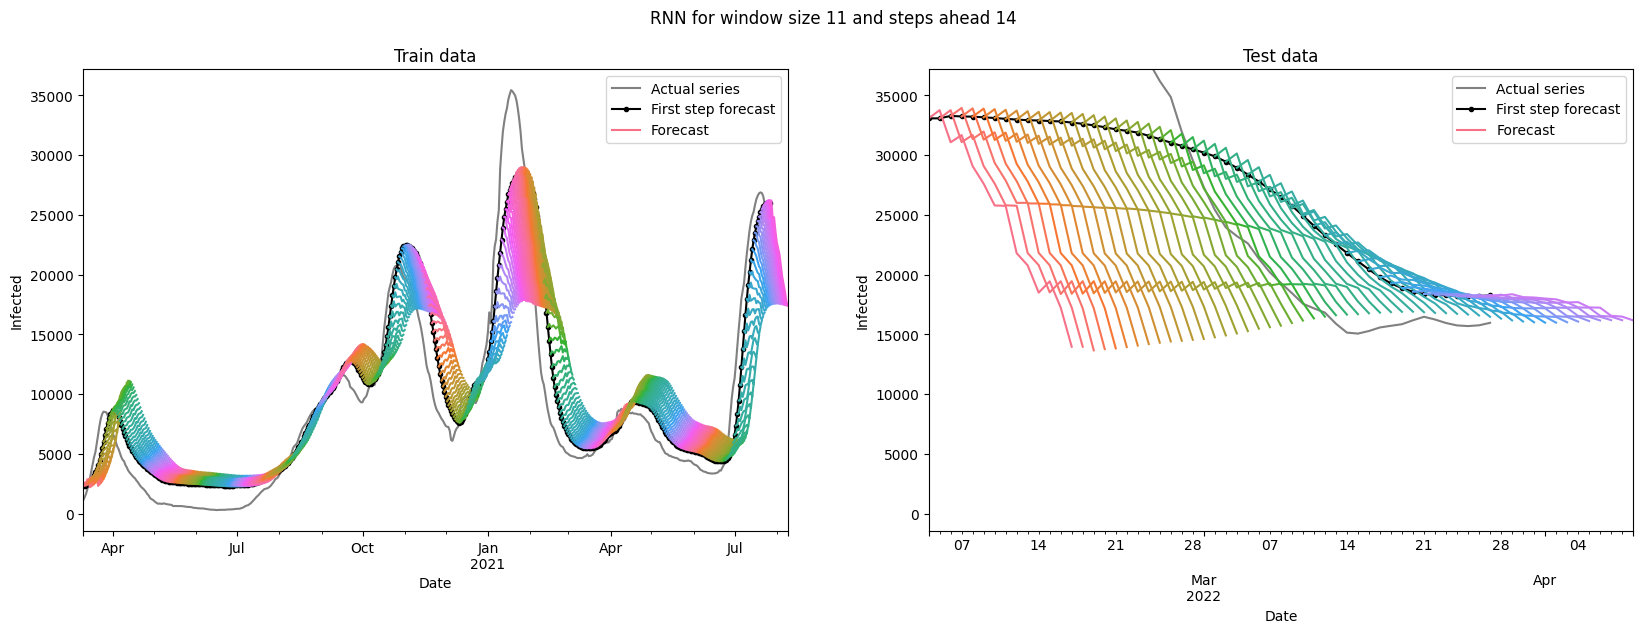

In [58]:
palette = dict(palette='husl', n_colors=64)
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# train data
ax1 = y_train['y_step_1'].plot(color='grey', zorder=0, ax=ax1)
y_fit_train['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_train, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])

# test data
ax2 = y_test['y_step_1'].plot(color='grey', zorder=0, ax=ax2)
y_fit_test['y_step_1'].plot(ax=ax2, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit_test, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Actual series', 'First step forecast', 'Forecast'])

# set title
ax1.set_title('Train data')
ax2.set_title('Test data')
fig.suptitle(f'RNN for window size {best_ws} and steps ahead 14')

# label axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Infected')
ax2.set_xlabel('Date')
ax2.set_ylabel('Infected')

# set same y scale for both axes
ax2.set_ylim(ax1.get_ylim())

plt.show()